# Used cars prices analysis and prediction

In this project, we are going to use three machine learning algorithm to do the prediction:
Multiple Linear Regression with LASSO panelty;
Random Forest;
XGboost

In [9]:
# import any tool if needed
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
from scipy.optimize import minimize
import pandas as pd 
import numpy as np
import seaborn as sns

import sklearn as sk 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Dataset Manipulation

In [3]:
df = pd.read_csv('cars_11_18.csv')
df.head

<bound method NDFrame.head of        Unnamed: 0  Unnamed: 0.1  price    year manufacturer     model  \
0               1             5  13995  2012.0         ford     f-150   
1               2             6   7995  2010.0    chevrolet   equinox   
2               3             7   8995  2011.0    chevrolet  traverse   
3               4             8  10995  2014.0         ford  explorer   
4               5             9  12995  2004.0          ram      2500   
...           ...           ...    ...     ...          ...       ...   
19557       61918        423777   5000  2009.0       toyota   corolla   
19558       61923        423803  25871  2017.0         ford  explorer   
19559       61928        423821  12995  2014.0       subaru   outback   
19560       61929        423823   9584  2012.0       toyota     camry   
19561       61930        423824   1000  2004.0         ford     f-150   

       condition    cylinders    fuel  odometer title_status transmission  \
0           good

In [4]:
# elminate duplicate rows and set the price limits to >50 and < 79980

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df.drop_duplicates()

df = df[df.price <79980]
df = df[df.price > 50]

df.head
#df.shape

<bound method NDFrame.head of        price    year manufacturer     model  condition    cylinders    fuel  \
0      13995  2012.0         ford     f-150       good  6 cylinders     gas   
1       7995  2010.0    chevrolet   equinox       good  4 cylinders     gas   
2       8995  2011.0    chevrolet  traverse       good  6 cylinders     gas   
3      10995  2014.0         ford  explorer       good  6 cylinders     gas   
4      12995  2004.0          ram      2500       good  6 cylinders  diesel   
...      ...     ...          ...       ...        ...          ...     ...   
19557   5000  2009.0       toyota   corolla       good  4 cylinders     gas   
19558  25871  2017.0         ford  explorer  excellent  6 cylinders     gas   
19559  12995  2014.0       subaru   outback  excellent  4 cylinders     gas   
19560   9584  2012.0       toyota     camry  excellent  4 cylinders     gas   
19561   1000  2004.0         ford     f-150       fair  8 cylinders     gas   

       odometer title

# Insight of predictors and Data Visualization

Histogram of response/major predictors

# Methods
Multiple Linear Regression with Lasso panelty/ Random forest / XGboost

In [5]:
# Multiple linear regression code



In [40]:
# Random forest code

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

df = pd.get_dummies(data = df)

Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:, 1:], df['price'], test_size=0.25, random_state=0)

rf_1 =  RandomForestRegressor(n_estimators=100,
                           criterion='mse',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=0.0001,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           bootstrap=True,
                           oob_score=True,
                           n_jobs=-1,
                           random_state=0,
                           verbose=0,
                           warm_start=True
                          )

rf_1.fit(Xtrain, ytrain)
predict_rf_1 = rf_1.predict(Xtest)
rf_mf1_accuracy = rf_1.score(Xtest, ytest)
print(mean_absolute_error(ytest.values, predict_rf_1))
print(r2_score(ytest.values, predict_rf_1))


rf_2 =  RandomForestRegressor(n_estimators=200,
                           criterion='mse',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=0.0001,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           bootstrap=True,
                           oob_score=True,
                           n_jobs=-1,
                           random_state=0,
                           verbose=0,
                           warm_start=True
                          )

rf_2.fit(Xtrain, ytrain)
predict_rf_2 = rf_max3.predict(Xtest)

print(mean_absolute_error(ytest.values, predict_rf_2))
print(r2_score(ytest.values, predict_rf_2))


1651.1462911720716
0.9140702921959201
0.9140702921959201
1648.3694294551567
0.9136829581350028


In [37]:
### RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}
# use random search to find out best hyper parameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(Xtrain, ytrain)
rf_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 18.1min finished


{'n_estimators': 1577, 'max_features': 'sqrt', 'bootstrap': False}

In [44]:
# See how we improved our random forest model

# set rf_1 as base model
print("Base model performance")
print("Mean absolute error is", mean_absolute_error(ytest.values, predict_rf_1))
print("Accuracy is", r2_score(ytest.values, predict_rf_1))

# impoved model
predict_rf_random = rf_random.predict(Xtest)
print("Random model performance")
print("Mean absolute error is", mean_absolute_error(ytest.values, predict_rf_random))
print("Accuracy is", r2_score(ytest.values, predict_rf_random))

# improvement
print('Improvement of {:0.2f}%.'.format( 100 * (r2_score(ytest.values, predict_rf_random)
                                                - r2_score(ytest.values, predict_rf_1)) / 
                                       r2_score(ytest.values, predict_rf_1)))

Base model performance
Mean absolute error is 1651.1462911720716
Accuracy is 0.9140702921959201
Random model performance
Mean absolute error is 1463.0718319078871
Accuracy is 0.9166058539654856
Improvement of 0.28%.


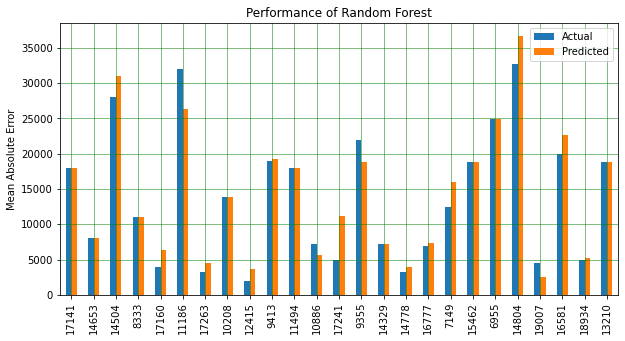

In [52]:
y_pred = rf_random.predict(Xtest)
df_check = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Absolute Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()
 


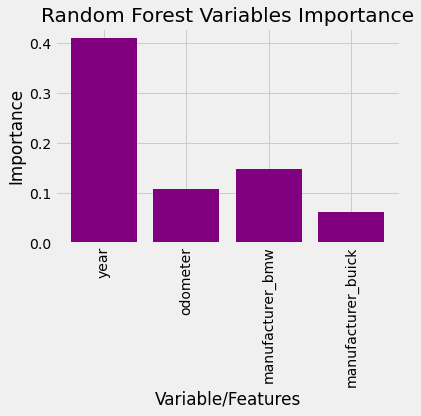

In [95]:

importances = rf_1.feature_importances_
features=Xtrain.columns
importances = importances[importances!=0]
importances = importances[importances > 0.05]
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'),color = 'purple')
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.show();



In [ ]:

# XGboost code

In [ ]:
# R squared score + MSE evaluation 